# Reverse-engineering of the surron ultrabee can bus

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json

---
## Reading data from Files

In [12]:
filesToRead = ["20240427_CAN_Trace_Motorrad_T000.asc", "20240427_CAN_Trace_Motorrad_T001.asc"]

dataPointsAsc = []
for fileName in filesToRead:
    with open(fileName) as f:
        content = f.readlines()
        for line in content:
            dataPointsAsc.append({
                "lineId": len(dataPointsAsc),
                "Id": line[101:len(line) - 1],
                "dlc": line[38:39],
                "msg": line[40:64],
                "time": line[:12],
            })

tmpCleanedArray = []

dataCombinedDictAsc = dataPointsAsc

for e in dataCombinedDictAsc:
    if (e["Id"] != '') & (e["Id"] != ' ') & (e["dlc"] != '') & (e["dlc"] != ' '):
        tmpCleanedArray.append(e)

dataCombinedDictAsc = tmpCleanedArray

for pos in range(len(dataCombinedDictAsc)):
    dataCombinedDictAsc[pos]["lineId"] = pos

dataCombinedDictCsv = dataCombinedDictAsc

df = pd.DataFrame(dataCombinedDictAsc)
df

,lineId,Id,dlc,msg,time
0,0,18,8,00 00 00 00 02 00 00 02,0.008923
1,1,258,8,25 03 00 00 00 00 00 28,0.017042
2,2,259,8,00 00 00 00 00 00 00 00,0.017292
3,3,260,8,B2 20 00 00 00 00 00 D2,0.017540
4,4,261,8,10 27 00 00 00 00 00 37,0.017788
...,...,...,...,...,...
55881,55881,259,8,FF FF 2C 04 5A 00 00 88,39.316511
55882,55882,260,8,B2 20 00 00 00 00 00 D2,39.316759
55883,55883,261,8,10 27 00 00 00 00 00 37,39.317007
55884,55884,417333248x,8,00 03 E7 03 2A 00 C0 0F,39.317296


---
## Extracting all Ids 

In [13]:
messengeIds = list(map(lambda row: (row[4]), data00))
uniqueIds = set(messengeIds)

df = pd.DataFrame(uniqueIds)
df

,0
0,514
1,545
2,801
3,774
4,771
5,515
6,417333504x
7,518
8,417333248x
9,798


---
## Massage CNT per Id

In [14]:
messagesPerId = []
for uniqueId in uniqueIds:
    var = list(map(lambda row: (row[3]), filter(lambda line: line[4] == uniqueId, dataCombined)))
    messagesPerId.append({
        "Id": uniqueId,
        "cnt": len(var),
        "msg": var
    })

df = pd.DataFrame(messagesPerId)
df

,Id,cnt,msg
0,514,672,"[08 01 00 00 00 00 00 09, 08 01 00 00 00 00 00..."
1,545,1307,"[00 5A 00 C5 03 00 00 54, 00 5A 00 C5 03 00 00..."
2,801,1,[C1 00 FF FF FF FF FF FF]
3,774,270,"[00 33 01 22 08 03 01 01, 00 33 01 22 08 03 01..."
4,771,672,"[03 03 01 02 00 00 00 00, 03 03 01 02 00 00 00..."
5,515,672,"[82 C4 4F F1 03 FB E4 3E, 83 B6 8F EC 43 FB 14..."
6,417333504x,6773,"[07 20 00 01 01 00 50 01, 07 20 00 01 01 00 50..."
7,518,674,"[38 01 37 02 00 00 00 00, 38 01 37 02 00 00 00..."
8,417333248x,6773,"[00 07 E7 03 9C 0F C2 0F, 00 07 E7 03 AD 0F C5..."
9,798,26,"[D7 2B 14 19 3F 86 7F B2, D7 2B 14 19 3F 86 7F..."


---
## Condense to unique messages

In [15]:
uniqueMessagesPerId = []

for message in messagesPerId:
    condensed = []

    for e in message["msg"]:
        if e not in condensed:
            condensed.append(e)

    uniqueMessagesPerId.append({
        "Id": message["Id"],
        "allCnt": message["cnt"],
        "uniqueCnt": len(condensed),
        "condensedMsg": condensed
    })

df = pd.DataFrame(uniqueMessagesPerId)
df

,Id,allCnt,uniqueCnt,condensedMsg
0,514,672,2,"[08 01 00 00 00 00 00 09, 09 01 00 00 00 00 00..."
1,545,1307,5,"[00 5A 00 C5 03 00 00 54, 01 5A 00 C5 03 00 00..."
2,801,1,1,[C1 00 FF FF FF FF FF FF]
3,774,270,1,[00 33 01 22 08 03 01 01]
4,771,672,1,[03 03 01 02 00 00 00 00]
5,515,672,123,"[82 C4 4F F1 03 FB E4 3E, 83 B6 8F EC 43 FB 14..."
6,417333504x,6773,6,"[07 20 00 01 01 00 50 01, 00 20 00 00 00 00 50..."
7,518,674,4,"[38 01 37 02 00 00 00 00, 38 03 37 02 00 00 00..."
8,417333248x,6773,272,"[00 07 E7 03 9C 0F C2 0F, 00 07 E7 03 AD 0F C5..."
9,798,26,1,[D7 2B 14 19 3F 86 7F B2]


---
## Extracting specific ids

In [16]:
data00Filtered = list(filter(lambda row: (row[4] == "417333248x"), data00))

df = pd.DataFrame(data00Filtered)
df

,0,1,2,3,4
0,0.018079,Rx,8,00 07 E7 03 9C 0F C2 0F,417333248x
1,0.043026,Rx,8,00 07 E7 03 AD 0F C5 0F,417333248x
2,0.058161,Rx,8,00 07 E7 03 C4 0F C5 0F,417333248x
3,0.078231,Rx,8,00 07 E7 03 CE 0F C2 0F,417333248x
4,0.098286,Rx,8,00 07 E7 03 E0 0F C2 0F,417333248x
...,...,...,...,...,...
4806,106.479.729,Rx,8,00 03 E7 03 2A 00 C0 0F,417333248x
4807,106.499.987,Rx,8,00 03 E7 03 28 00 C0 0F,417333248x
4808,106.519.796,Rx,8,00 03 E7 03 28 00 C0 0F,417333248x
4809,106.540.856,Rx,8,00 03 E7 03 28 00 C0 0F,417333248x


---
## Properly information For Display

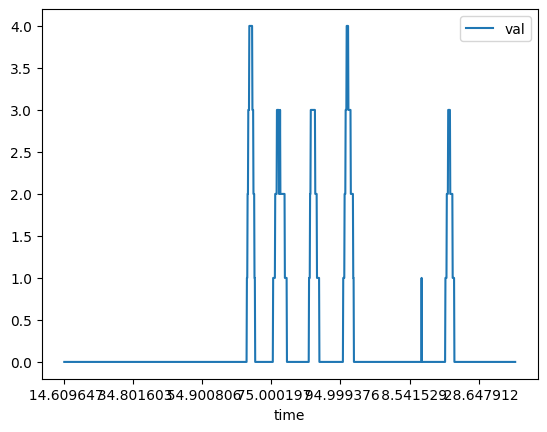

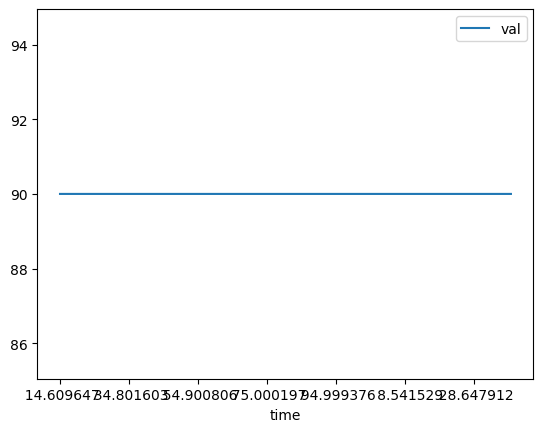

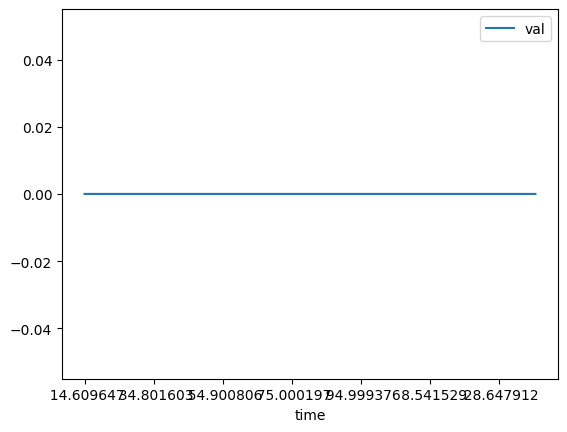

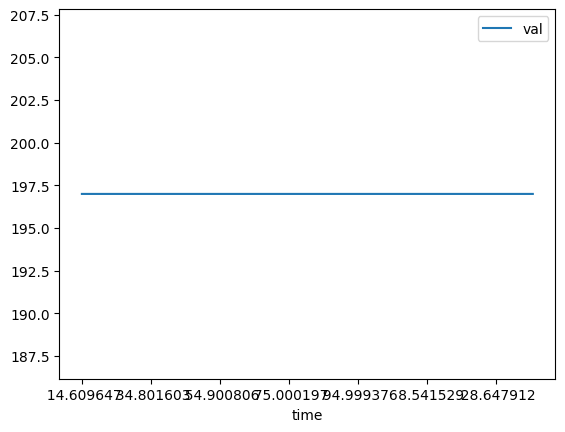

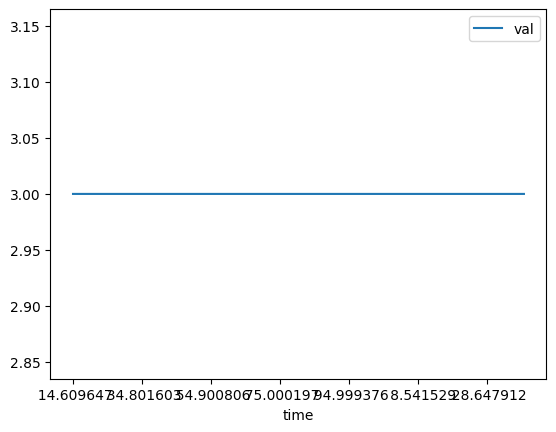

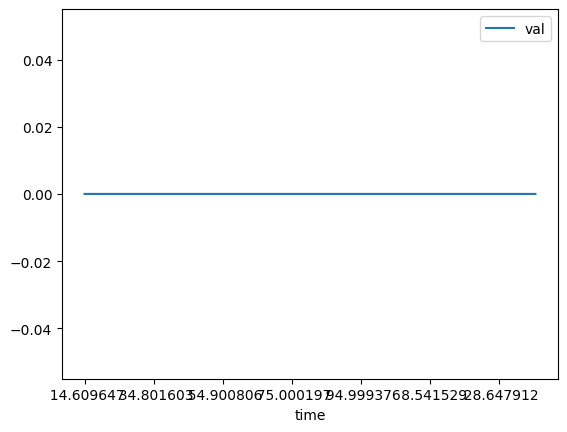

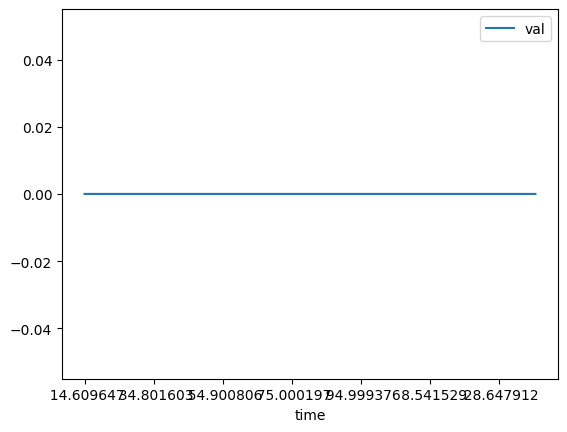

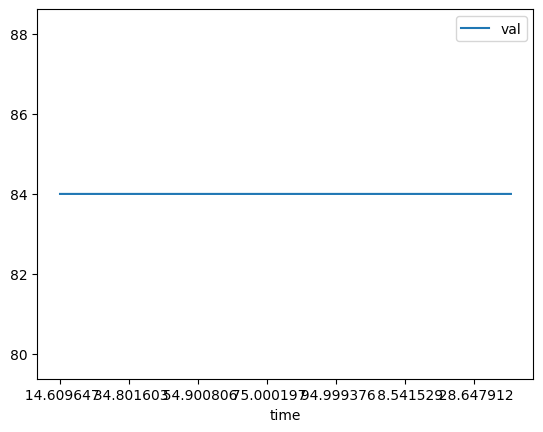

In [18]:
searchedId = "545"
dataByte = 0


for pos in range(8):
    dataByte = pos
    plotData = map(lambda row: ({"time": row["time"], "val": int(row["msg"].split()[dataByte], 16)}),
                   list(filter(lambda item: item['Id'] == searchedId, dataCombinedDictCsv)))
    
    df = pd.DataFrame(plotData).plot("time", "val")

